# Helmholtz Free Energy
The thermodynamic phase stability can be evaluated by comparing the Helmholtz free energy of different phases. So being able to calculate the Helmholtz free energy is an essential step towards calculating the full phase diagram. In the following there approximations are introduced to calculate the Helmholtz free energy, starting with the harmonic approximation, followed by the quasi-harmonic approximation which also includes the volume expansion and finally thermodynamic integration is used to quantify the anharmonic contributions. This addiabative approach to calculate the Helmholtz free energy is typically used in combination with ab-initio simulation methods like density functional theory, still here the approach is demonstrated with the [LAMMPS](https://lammps.org/) simulation code and the Morse potential.

Starting with the import of the required python modules: 

In [1]:
from ase.build import bulk
import numpy as np
from atomistics.workflows import (
    optimize_positions_and_volume,
    LangevinWorkflow,
    get_hesse_matrix,
    get_thermal_properties_for_harmonic_approximation,
    get_tasks_for_harmonic_approximation,
    analyse_results_for_harmonic_approximation,
    get_tasks_for_quasi_harmonic_approximation,
    analyse_results_for_quasi_harmonic_approximation,
    get_thermal_properties_for_quasi_harmonic_approximation,
)
from atomistics.calculators import (
    evaluate_with_lammpslib_library_interface,
    evaluate_with_lammpslib,
    get_potential_by_name,
    evaluate_with_hessian,
)
from pylammpsmpi import LammpsASELibrary
from phonopy.units import VaspToTHz
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas
import scipy.constants

/srv/conda/envs/notebook/lib/python3.10/site-packages/atomistics/calculators/__init__.py:63: UserWarning: calc_static_with_qe(), evaluate_with_qe() and optimize_positions_and_volume_with_qe() are not available as the import of the module named 'pwtools' failed.
  raise_warning(module_list=quantum_espresso_function, import_error=e)


Followed by the selection of the reference element and the definition of the Morse interatomic potential:

In [2]:
structure_bulk = bulk("Al", cubic=True)
df_pot_selected = pandas.DataFrame(
    {
        "Config": [
            ["pair_style morse/smooth/linear 9.0", "pair_coeff * * 0.5 1.8 2.95"]
        ],
        "Filename": [[]],
        "Model": ["Morse"],
        "Name": ["Morse"],
        "Species": [["Al"]],
    }
)

As a prerequisite the volume and positions of the atomistic structure are optimized to calculate the Helmholtz of the equilibrium structure:

In [3]:
task_dict = optimize_positions_and_volume(structure=structure_bulk)
result_dict = evaluate_with_lammpslib(
    task_dict=task_dict,
    potential_dataframe=df_pot_selected,
)
structure_opt = result_dict["structure_with_optimized_positions_and_volume"]

Finally, the size of the atomistic structure is increased by repeating the structure in all three directions three times: 

In [4]:
structure = structure_opt.repeat([3, 3, 3])

The increased structure is required for all three approximations, for the harmonic and quasi-harmonic approximation it is required to evaluate the phonons up to an interaction range of 10 Angstrom and for the thermodynamic integration the larger supercell provides improved thermodynamic stability when calculating molecular dynamics trajectories at finite temperatures.

## Harmonic Approximation

The harmonic approximation is calculated using the finite displacement method using the [phonopy](https://phonopy.github.io/phonopy/) package. In the `atomistics` package the [phonopy](https://phonopy.github.io/phonopy/) workflow is implemented in the `PhonopyWorkflow` object. Following the typical three step process of generating the structures `generate_structures()` evaluating them with the [LAMMPS](https://lammps.org/) simulation code using the `evaluate_with_lammpslib()` function and analysing the results using the `analyse_structures()` function the thermodynamic properties can be calculated using the `get_thermal_properties()` function.

In [6]:
task_dict, phonopy_obj = get_tasks_for_harmonic_approximation(
    structure=structure_opt,
    interaction_range=10,
    factor=VaspToTHz,
    displacement=0.01,
    primitive_matrix=None,
    number_of_snapshots=None,
)
result_dict = evaluate_with_lammpslib(
    task_dict=task_dict,
    potential_dataframe=df_pot_selected,
)
phonopy_dict = analyse_results_for_harmonic_approximation(
    phonopy=phonopy_obj,
    output_dict=result_dict,
    dos_mesh=20,
    number_of_snapshots=None,
)
term_base_dict = get_thermal_properties_for_harmonic_approximation(
    phonopy=phonopy_obj,
    t_min=1,
    t_max=1500,
    t_step=250,
    temperatures=None,
    cutoff_frequency=None,
    pretend_real=False,
    band_indices=None,
    is_projection=False,
)
term_base_dict

{'temperatures': array([1.000e+00, 2.510e+02, 5.010e+02, 7.510e+02, 1.001e+03, 1.251e+03,
        1.501e+03]),
 'volumes': array([66.29787349, 66.29787349, 66.29787349, 66.29787349, 66.29787349,
        66.29787349, 66.29787349]),
 'free_energy': array([ 0.3054683 ,  0.26911103,  0.08807443, -0.2090548 , -0.58871765,
        -1.03150448, -1.52522672]),
 'entropy': array([1.12350786e-14, 4.12565469e+01, 9.50730111e+01, 1.32185181e+02,
        1.59664975e+02, 1.81349904e+02, 1.99221616e+02]),
 'heat_capacity': array([        nan, 63.97199066, 88.27044589, 94.37971636, 96.67969872,
        97.77513519, 98.37869945])}

The dictionary returned by the `get_thermal_properties()` function contains the temperature dependence of the following thermodynamic properties: Helmholtz free energy `free_energy`, Entropy `entropy` and the heat capcity at constant volume `heat_capacity`. In addition, the temperature is also included in the result dictionary to simplify the plotting of the results. The results are compared to the other approximations in the following.

## Quasi-Harmonic Approximation

The quasi-harmonic approximation extends the harmonix approximation by including the volume expansion. In the `atomistics` package this is implemented with the `QuasiHarmonicWorkflow` which internally is a combination of the `EnergyVolumeCurveWorkflow` and the `PhonopyWorkflow` introduced above. Consequently, the input parameters for the `QuasiHarmonicWorkflow` are a superset of the inputs of these workflows: 

In [10]:
task_dict, qh_dict = get_tasks_for_quasi_harmonic_approximation(
    structure=structure_opt,
    num_points=11,
    vol_range=0.05,
    interaction_range=10,
    factor=VaspToTHz,
    displacement=0.01,
)
result_dict = evaluate_with_lammpslib(
    task_dict=task_dict,
    potential_dataframe=df_pot_selected,
)
eng_internal_dict, phonopy_collect_dict = analyse_results_for_quasi_harmonic_approximation(
    qh_dict=qh_dict,
    output_dict=result_dict,
    dos_mesh=20,
    number_of_snapshots=None,
)
term_qh_dict = get_thermal_properties_for_quasi_harmonic_approximation(
    eng_internal_dict=eng_internal_dict,
    task_dict=task_dict,
    qh_dict=qh_dict,
    fit_type="polynomial",
    fit_order=3,
    t_min=1,
    t_max=1500,
    t_step=250,
    temperatures=None,
    cutoff_frequency=None,
    pretend_real=False,
    band_indices=None,
    is_projection=False,
    quantum_mechanical=True,
)
term_qh_dict

{'temperatures': array([1.000e+00, 2.510e+02, 5.010e+02, 7.510e+02, 1.001e+03, 1.251e+03,
        1.501e+03]),
 'volumes': [66.78514133015105,
  66.90026112725911,
  67.24613966479,
  67.66763147370493,
  68.13272183956198,
  68.63838223128475,
  69.19001915731252],
 'free_energy': array([ 0.30135186,  0.26231576,  0.07072568, -0.24471542, -0.6511058 ,
        -1.12997804, -1.67041733]),
 'entropy': array([1.20798696e-13, 4.25798733e+01, 9.77764788e+01, 1.36321763e+02,
        1.65329131e+02, 1.88652634e+02, 2.08299831e+02]),
 'heat_capacity': array([        nan, 64.8675424 , 88.84136922, 94.80149607, 97.01828199,
        98.06138195, 98.62976785])}

In analogy to the `get_thermal_properties()` function of the `PhonopyWorkflow` the `get_thermal_properties()` function of the `QuasiHarmonicWorkflow` returns a dictionary with the temperature dependence of the thermodynamic properties. The volume at finite temperature is included as an additional output. 

Furthermore, the `QuasiHarmonicWorkflow` adds the ability to calculate the volume expansion with the classical harmonic oscillator rather than the quantum mechanical osicllator which is used by default:

In [11]:
term_qh_cl_dict = get_thermal_properties_for_quasi_harmonic_approximation(
    eng_internal_dict=eng_internal_dict,
    task_dict=task_dict,
    qh_dict=qh_dict,
    fit_type="polynomial",
    fit_order=3,
    t_min=1,
    t_max=1500,
    t_step=250,
    temperatures=None,
    cutoff_frequency=None,
    pretend_real=False,
    band_indices=None,
    is_projection=False,
    quantum_mechanical=False,
)
term_qh_cl_dict

{'free_energy': array([ 0.00653974,  0.20391946,  0.04183981, -0.26289441, -0.66375638,
        -1.1392132 ]),
 'temperatures': array([   1,  251,  501,  751, 1001, 1251]),
 'volumes': [66.29913676045436,
  66.70960351611461,
  67.13997946807174,
  67.59364774175592,
  68.07505265001919,
  68.59023265333806]}

In this case the dictionary of thermal properties calculated by the `get_thermal_properties()` function only contains the Helmholtz free energy `free_energy`, the volume at finite temperature `volumes` and the corresponding temperature `termpatures`.

For the comparison of the harmonic approximation and the quasi-harmonic approximation the thermodynamic properties are visualized in the following. Given the coarse sampling of the temperature dependence these graphs look a bit rough. A better choice for the temperature step would be 50K rather than 250K. Here the larger temperature step is chosen to minimize the computational cost. 

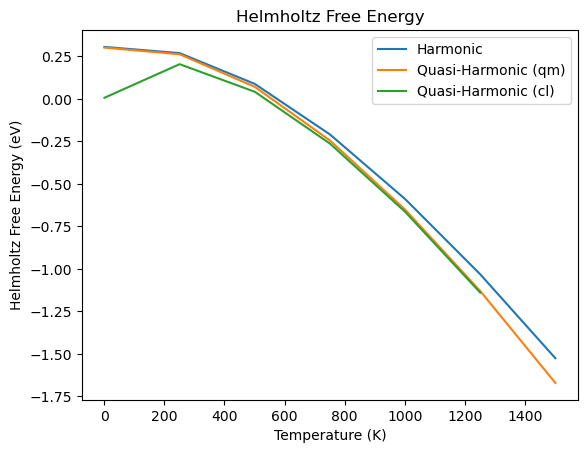

In [12]:
plt.title("Helmholtz Free Energy")
plt.plot(
    term_base_dict["temperatures"], term_base_dict["free_energy"], label="Harmonic"
)
plt.plot(
    term_qh_dict["temperatures"],
    term_qh_dict["free_energy"],
    label="Quasi-Harmonic (qm)",
)
plt.plot(
    term_qh_cl_dict["temperatures"],
    term_qh_cl_dict["free_energy"],
    label="Quasi-Harmonic (cl)",
)
plt.xlabel("Temperature (K)")
plt.ylabel("Helmholtz Free Energy (eV)")
plt.legend()

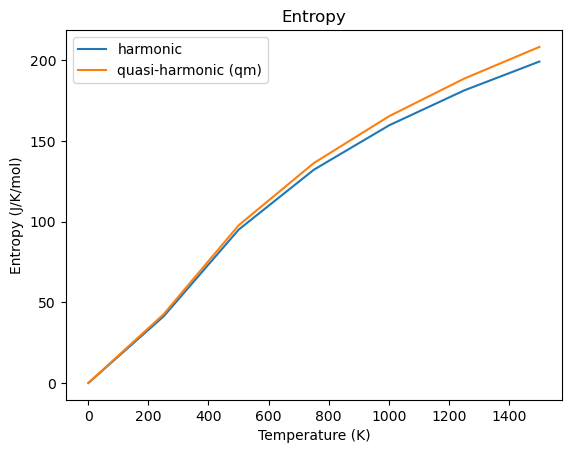

In [13]:
plt.title("Entropy")
plt.plot(term_base_dict["temperatures"], term_base_dict["entropy"], label="harmonic")
plt.plot(
    term_qh_dict["temperatures"], term_qh_dict["entropy"], label="quasi-harmonic (qm)"
)
plt.xlabel("Temperature (K)")
plt.ylabel("Entropy (J/K/mol)")
plt.legend()

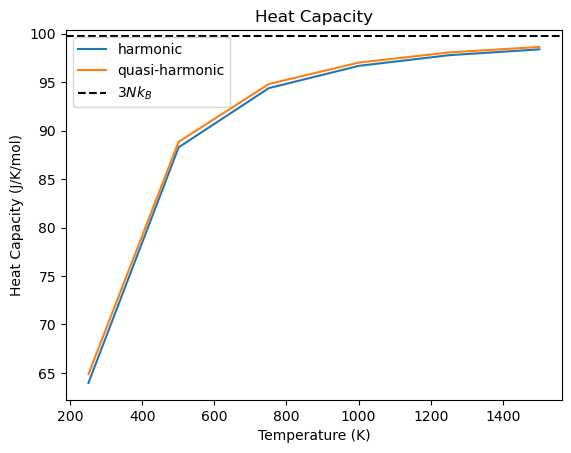

In [14]:
plt.title("Heat Capacity")
plt.plot(
    term_base_dict["temperatures"], term_base_dict["heat_capacity"], label="harmonic"
)
plt.plot(
    term_qh_dict["temperatures"], term_qh_dict["heat_capacity"], label="quasi-harmonic"
)
plt.axhline(
    3 * scipy.constants.Boltzmann * scipy.constants.Avogadro * len(structure_opt),
    color="black",
    linestyle="--",
    label="$3Nk_B$",
)
plt.xlabel("Temperature (K)")
plt.ylabel("Heat Capacity (J/K/mol)")
plt.legend()

## Thermo Dynamic Integration

To include the anharmonic contribution to the free energy thermo dynamic integration is used to integrate the internal energy between the quasi-harmonic reference and the full anharmonic molecular dynamics calculation. For the choice of computational efficiency molecular dynamics trajectories with 3000 steps are using and a set of five lambda values between 0.0 and 1.0. Again, increasing the number of lambda values from 5 to 11 can improve the approximation.

In [15]:
steps = 3000
steps_lst = list(range(steps))
lambda_lst = np.linspace(0.0, 1.0, 5)

From the finite temperature volume of the `QuasiHarmonicWorkflow` above the finite temperature lattice constant is calculated:

In [16]:
lattice_constant_lst = np.array(term_qh_dict["volumes"]) ** (1 / 3)
temperature_lst = term_qh_dict["temperatures"]

The thermodynamic integration workflow consists of two loops. The first loop iterates over the different temperatures and the corresponding finite temperature lattice constants while the second inner loop iterates over the different lambda parameters. In the outter loop the `PhonopyWorkflow` workflow is used to calculate the finite temperature force constants which can be accessed from the `PhonopyWorkflow` using the `get_hesse_matrix()` function. In addition the `evaluate_with_lammpslib()` function is used in the outter loop as well to calculate the equilibrium energy at finite volume. Finally, in the inner loop the `LangevinWorkflow` is used to calculate the molecular dynamics trajectory with both the forces and the energy being mixed in dependence of the lambda parameter from the Hessian calculation `evaluate_with_hessian()` and the [LAMMPS](https://lammps.org/) calculation `evaluate_with_lammpslib_library_interface()`. Here the [LAMMPS](https://lammps.org/) library interface is used to evaluate multiple structures one after another. Finally the lambda dependence is fitted and the integral from 0 to 1 is calculated:

In [ ]:
free_energy_lst, eng_lambda_dependence_lst = [], []
for lattice_constant, temperature in zip(lattice_constant_lst, temperature_lst):
    structure = bulk("Al", a=lattice_constant, cubic=True).repeat([3, 3, 3])
    equilibrium_lammps = evaluate_with_lammpslib(
        task_dict={"calc_energy": structure}, potential_dataframe=df_pot_selected
    )["energy"]
    task_dict, phonopy_obj = get_tasks_for_harmonic_approximation(
        structure=structure,
        interaction_range=10,
        factor=VaspToTHz,
        displacement=0.01,
    )
    result_dict = evaluate_with_lammpslib(
        task_dict=task_dict,
        potential_dataframe=df_pot_selected,
    )
    phonopy_dict = analyse_results_for_harmonic_approximation(
        phonopy=phonopy_obj,
        output_dict=result_dict,
        dos_mesh=20,
        number_of_snapshots=None,
    )
    energy_pot_all_lst, energy_mean_lst, energy_kin_all_lst = [], [], []
    for lambda_parameter in lambda_lst:
        thermo_eng_pot_lst, thermo_eng_kin_lst = [], []
        workflow_md_thermo = LangevinWorkflow(
            structure=structure,
            temperature=temperature,
            overheat_fraction=2.0,
            damping_timescale=100.0,
            time_step=1,
        )
        lmp = LammpsASELibrary(
            working_directory=None,
            cores=1,
            comm=None,
            logger=None,
            log_file=None,
            library=None,
            disable_log_file=True,
        )
        for i in tqdm(steps_lst):
            task_dict = workflow_md_thermo.generate_structures()
            hessian_dict = evaluate_with_hessian(
                task_dict=task_dict,
                structure_equilibrium=structure,
                force_constants=get_hesse_matrix(force_constants=phonopy_obj.force_constants),
                bulk_modulus=0,
                shear_modulus=0,
            )
            lammps_dict = evaluate_with_lammpslib_library_interface(
                task_dict=task_dict,
                potential_dataframe=df_pot_selected,
                lmp=lmp,
            )
            result_dict = {
                "forces": {
                    0: (1 - lambda_parameter) * hessian_dict["forces"][0]
                    + lambda_parameter * lammps_dict["forces"][0]
                },
                "energy": {
                    0: (1 - lambda_parameter) * hessian_dict["energy"][0]
                    + lambda_parameter * (lammps_dict["energy"][0] - equilibrium_lammps)
                },
            }
            eng_pot, eng_kin = workflow_md_thermo.analyse_structures(
                output_dict=result_dict
            )
            thermo_eng_pot_lst.append(eng_pot)
            thermo_eng_kin_lst.append(eng_kin)
        lmp.close()
        thermo_energy = np.array(thermo_eng_pot_lst) + np.array(thermo_eng_kin_lst)
        energy_mean_lst.append(np.mean(thermo_energy[1000:]))
        energy_pot_all_lst.append(thermo_eng_pot_lst)
        energy_kin_all_lst.append(thermo_eng_kin_lst)
    eng_lambda_dependence_lst.append(np.array(energy_mean_lst) / len(structure) * 1000)
    fit = np.poly1d(
        np.polyfit(lambda_lst, np.array(energy_mean_lst) / len(structure) * 1000, 3)
    )
    integral = np.polyint(fit)
    free_energy_lst.append(integral(1.0) - integral(0.0))

IOStream.flush timed out
IOStream.flush timed out


## Summary

The Helmholtz free energy for all three approximations is compared in the following:

In [ ]:
plt.title("Helmholtz Free Energy")
plt.plot(
    term_base_dict["temperatures"], term_base_dict["free_energy"], label="Harmonic"
)
plt.plot(
    term_qh_dict["temperatures"], term_qh_dict["free_energy"], label="Quasi-Harmonic"
)
plt.plot(
    term_qh_dict["temperatures"],
    term_qh_dict["free_energy"] - np.array(free_energy_lst) / 1000,
    label="Thermodynamic Integration",
)
plt.xlabel("Temperature (K)")
plt.ylabel("Helmholtz Free Energy (eV)")
plt.legend()